In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc

from tqdm import tqdm
train = pd.read_csv('/Users/anishpawar/MTech/Sem-2/IVP/Project_PreProc_Final_Report/IVP-EEG-Classification/hms-harmful-brain-activity-classification/train.csv')
print('Train shape', train.shape )
display( train.head(10) )

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [2]:
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", message=".*", category=UserWarning)


In [3]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

directory_path = 'EEG_Spectrograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

In [4]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = "db8"

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [5]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

In [6]:
root = '/Users/anishpawar/MTech/Sem-2/IVP/Project_PreProc_Final_Report/IVP-EEG-Classification/hms-harmful-brain-activity-classification'

metadata = pd.read_csv(f'{root}/train.csv')
metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [7]:
metadata['expert_consensus'].unique()

array(['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD'], dtype=object)

In [8]:
metadata.iloc[0]

eeg_id                              1628180742
eeg_sub_id                                   0
eeg_label_offset_seconds                   0.0
spectrogram_id                          353733
spectrogram_sub_id                           0
spectrogram_label_offset_seconds           0.0
label_id                             127492639
patient_id                               42516
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
Name: 0, dtype: object

In [9]:
def getWindowsfromEEG(loc):

    labelMap = {'Seizure':0,'GPD':1,'LRDA':2,'Other':3,'GRDA':4,'LPD':5}

    subSet = metadata.iloc[loc]
    eeg_id = subSet['eeg_id']

    labels = np.array([int(subSet['seizure_vote']), int(subSet['lpd_vote']) , int(subSet['gpd_vote'])
                       ,int(subSet['lrda_vote']), int(subSet['grda_vote']), int(subSet['other_vote'])])

    consensus = labelMap[subSet['expert_consensus']]

    eeg = pd.read_parquet(f'{root}/train_eegs/{eeg_id}.parquet')

    fs = 200
    eeg["time"] = eeg.index / fs
    eeg.set_index("time", inplace=True)
    eeg.index

    offSet = int(subSet['eeg_label_offset_seconds'])

    toRet = []

    toRet.append(eeg.loc[offSet+20:offSet+30])
    return int(subSet['eeg_sub_id']),offSet,toRet,eeg,np.array(consensus), np.array(labels)


In [10]:
sub_id,offSet,sliced_eegs,OG_eeg, consensus, labels = getWindowsfromEEG(3)

In [11]:
consensus

array(0)

In [12]:
labels

array([3, 0, 0, 0, 0, 0])

In [13]:
sliced_eegs[0]

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
time,,,,,,,,,,,,,,,,,,,,
38.000,-119.760002,-111.290001,-115.400002,-130.970001,-161.729996,-119.080002,-115.900002,-225.440002,-357.660004,-202.929993,-82.680000,-98.870003,-85.010002,-122.919998,-345.010010,-110.099998,-90.800003,-108.239998,-113.790001,88.849998
38.005,-128.000000,-129.570007,-132.500000,-137.639999,-170.270004,-134.130005,-114.870003,-228.460007,-382.679993,-226.190002,-96.650002,-119.050003,-121.379997,-169.169998,-369.040009,-94.010002,-112.519997,-128.630005,-125.169998,119.779999
38.010,-118.480003,-115.709999,-146.000000,-139.589996,-162.300003,-129.449997,-118.019997,-230.119995,-366.980011,-224.800003,-105.540001,-98.989998,-93.440002,-162.880005,-373.739990,-89.900002,-70.930000,-133.089996,-128.190002,125.760002
38.015,-121.690002,-112.610001,-140.639999,-136.500000,-151.679993,-117.339996,-105.080002,-229.289993,-376.839996,-234.440002,-113.410004,-109.910004,-107.129997,-190.130005,-388.690002,-91.230003,-98.650002,-145.800003,-133.860001,83.150002
38.020,-126.500000,-119.919998,-148.729996,-157.929993,-147.429993,-115.580002,-98.440002,-233.110001,-393.200012,-245.979996,-124.379997,-125.279999,-115.879997,-190.380005,-417.929993,-120.879997,-116.160004,-175.220001,-150.199997,79.570000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47.980,-124.690002,-148.089996,-210.899994,-175.639999,-134.070007,-85.010002,-122.260002,-86.949997,-168.470001,-185.539993,-151.160004,-125.910004,-129.630005,-134.559998,-110.930000,-132.050003,-133.570007,-160.570007,-143.289993,102.959999
47.985,-121.389999,-155.729996,-115.080002,-157.270004,-128.389999,-132.479996,-96.570000,-82.550003,-169.990005,-177.429993,-141.750000,-141.009995,-154.000000,-133.970001,-116.269997,-131.320007,-60.869999,-170.970001,-147.389999,115.629997
47.990,-111.139999,-133.550003,-120.449997,-174.509995,-140.449997,-106.540001,-126.930000,-88.470001,-149.250000,-177.360001,-150.860001,-126.750000,-129.089996,-172.600006,-111.599998,-122.489998,-162.380005,-164.809998,-147.750000,122.860001


In [14]:
FEATS

[['Fp1', 'F7', 'T3', 'T5', 'O1'],
 ['Fp1', 'F3', 'C3', 'P3', 'O1'],
 ['Fp2', 'F8', 'T4', 'T6', 'O2'],
 ['Fp2', 'F4', 'C4', 'P4', 'O2']]

In [15]:
from scipy.signal import butter, filtfilt

def apply_lpf(data, sampling_rate=200, cutoff_freq=10, order=5):

    nyquist_freq = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)

    return filtered_data

In [16]:
import librosa

def spectrogram_from_eeg(eeg_id, display=False,USE_WAVELET='db16'):
    

    sub_id,offSets,sliced_eegs,OG_eeg,consensus, labels = getWindowsfromEEG(eeg_id)
    eeg = sliced_eegs[0]
    

    print(eeg.shape)
    
    if display: plt.figure(figsize=(10,7))

    retSpecs = []
    retEEGs = []
    ogEEGs = []

    img = np.zeros((128,128),dtype='float32')
    signals = []
    signalsX = []
    signalsXOG = []
    for k in range(4):
        COLS = FEATS[k]

        tempSpec= np.zeros((128,128))

        if USE_WAVELET=="LPF10" or USE_WAVELET=="LPF20" or USE_WAVELET == "None":
            temp = np.zeros((2001))
            tempOG = np.zeros((2001))
        else:
            temp = np.zeros((2002))
            tempOG = np.zeros((2001))
        
        for kk in range(4):
        
    
            x = eeg[COLS[kk]] - eeg[COLS[kk+1]]
            tempOG+=x
    
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            
            if USE_WAVELET=='LPF10':
        
                x = apply_lpf(x,cutoff_freq=10)
            elif USE_WAVELET=='LPF20':
        
                x = apply_lpf(x,cutoff_freq=20)
            else:
                x = denoise(x, wavelet=USE_WAVELET)

            temp+=x
            signals.append(x)
            
    
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//128, 
                n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

    
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

    
            mel_spec_db = (mel_spec_db+40)/40 
            tempSpec += mel_spec_db
        temp/=4.0
        tempOG/=4.0
        
        signalsX.append(temp)    
        signalsXOG.append(tempOG)


        tempSpec /= 4.0

        img  = np.vstack((img,tempSpec))

        print(f'Image shape is: {img.shape}')

    retSpecs.append(img[128:])

    retEEGs.append(np.array(signalsX))
    ogEEGs.append(np.array(signalsXOG))


    return np.array(retSpecs),np.array(retEEGs),np.array(ogEEGs), consensus, labels


In [17]:
!rm -r Processed_Specs

In [18]:
!mkdir Processed_Specs

### Plotting Before and after

In [35]:
import matplotlib.pyplot as plt
import numpy as np



def plotEEG(EEG1,EEG2,USE_WAVELET):
    num_rows = 10
    num_cols = 6

    x1 = EEG1[0].shape[0]
    x2 = EEG2[0].shape[0]
    

    fig = plt.figure(figsize=(20, 20)) 
    figsL = ['LL','LP',"RP","RR"]
    for i in tqdm(range(1,9)):
        fig.add_subplot(4,2,i)
        if i%2==1:
            
            plt.title(label=f'{figsL[(i-1)//2]} - Original',fontsize=20)
            plt.plot(range(x1),(EEG1[(i-1)//2]))

        else:
        # if USE_WAVELET:
            plt.title(label=f'{figsL[(i-1)//2]} - Filtered',fontsize=20)
            # else:
            #     plt.title(label=f'{figsL[(i-1)//2]} - Filtered')
            plt.plot(range(x2),(EEG2[(i-1)//2]))

    fig.suptitle(f'EEG Filtered Using {USE_WAVELET}',fontsize=40)
    plt.tight_layout()
    plt.show()


In [36]:
def processAndPlot(eeg_id,USE_WAVELET='db1',plot=False):
    
    retSpecs,retEEGs,ogEEGS, consensus, labels = spectrogram_from_eeg(eeg_id,USE_WAVELET=USE_WAVELET)
    # print(retEEGs[0])
    # print(r)
    if plot:
        plotEEG(ogEEGS[0],retEEGs[0],USE_WAVELET=USE_WAVELET)
    return retEEGs,ogEEGS

(2001, 20)
Image shape is: (256, 128)
Image shape is: (384, 128)
Image shape is: (512, 128)
Image shape is: (640, 128)


100%|██████████| 8/8 [00:00<00:00, 102.39it/s]


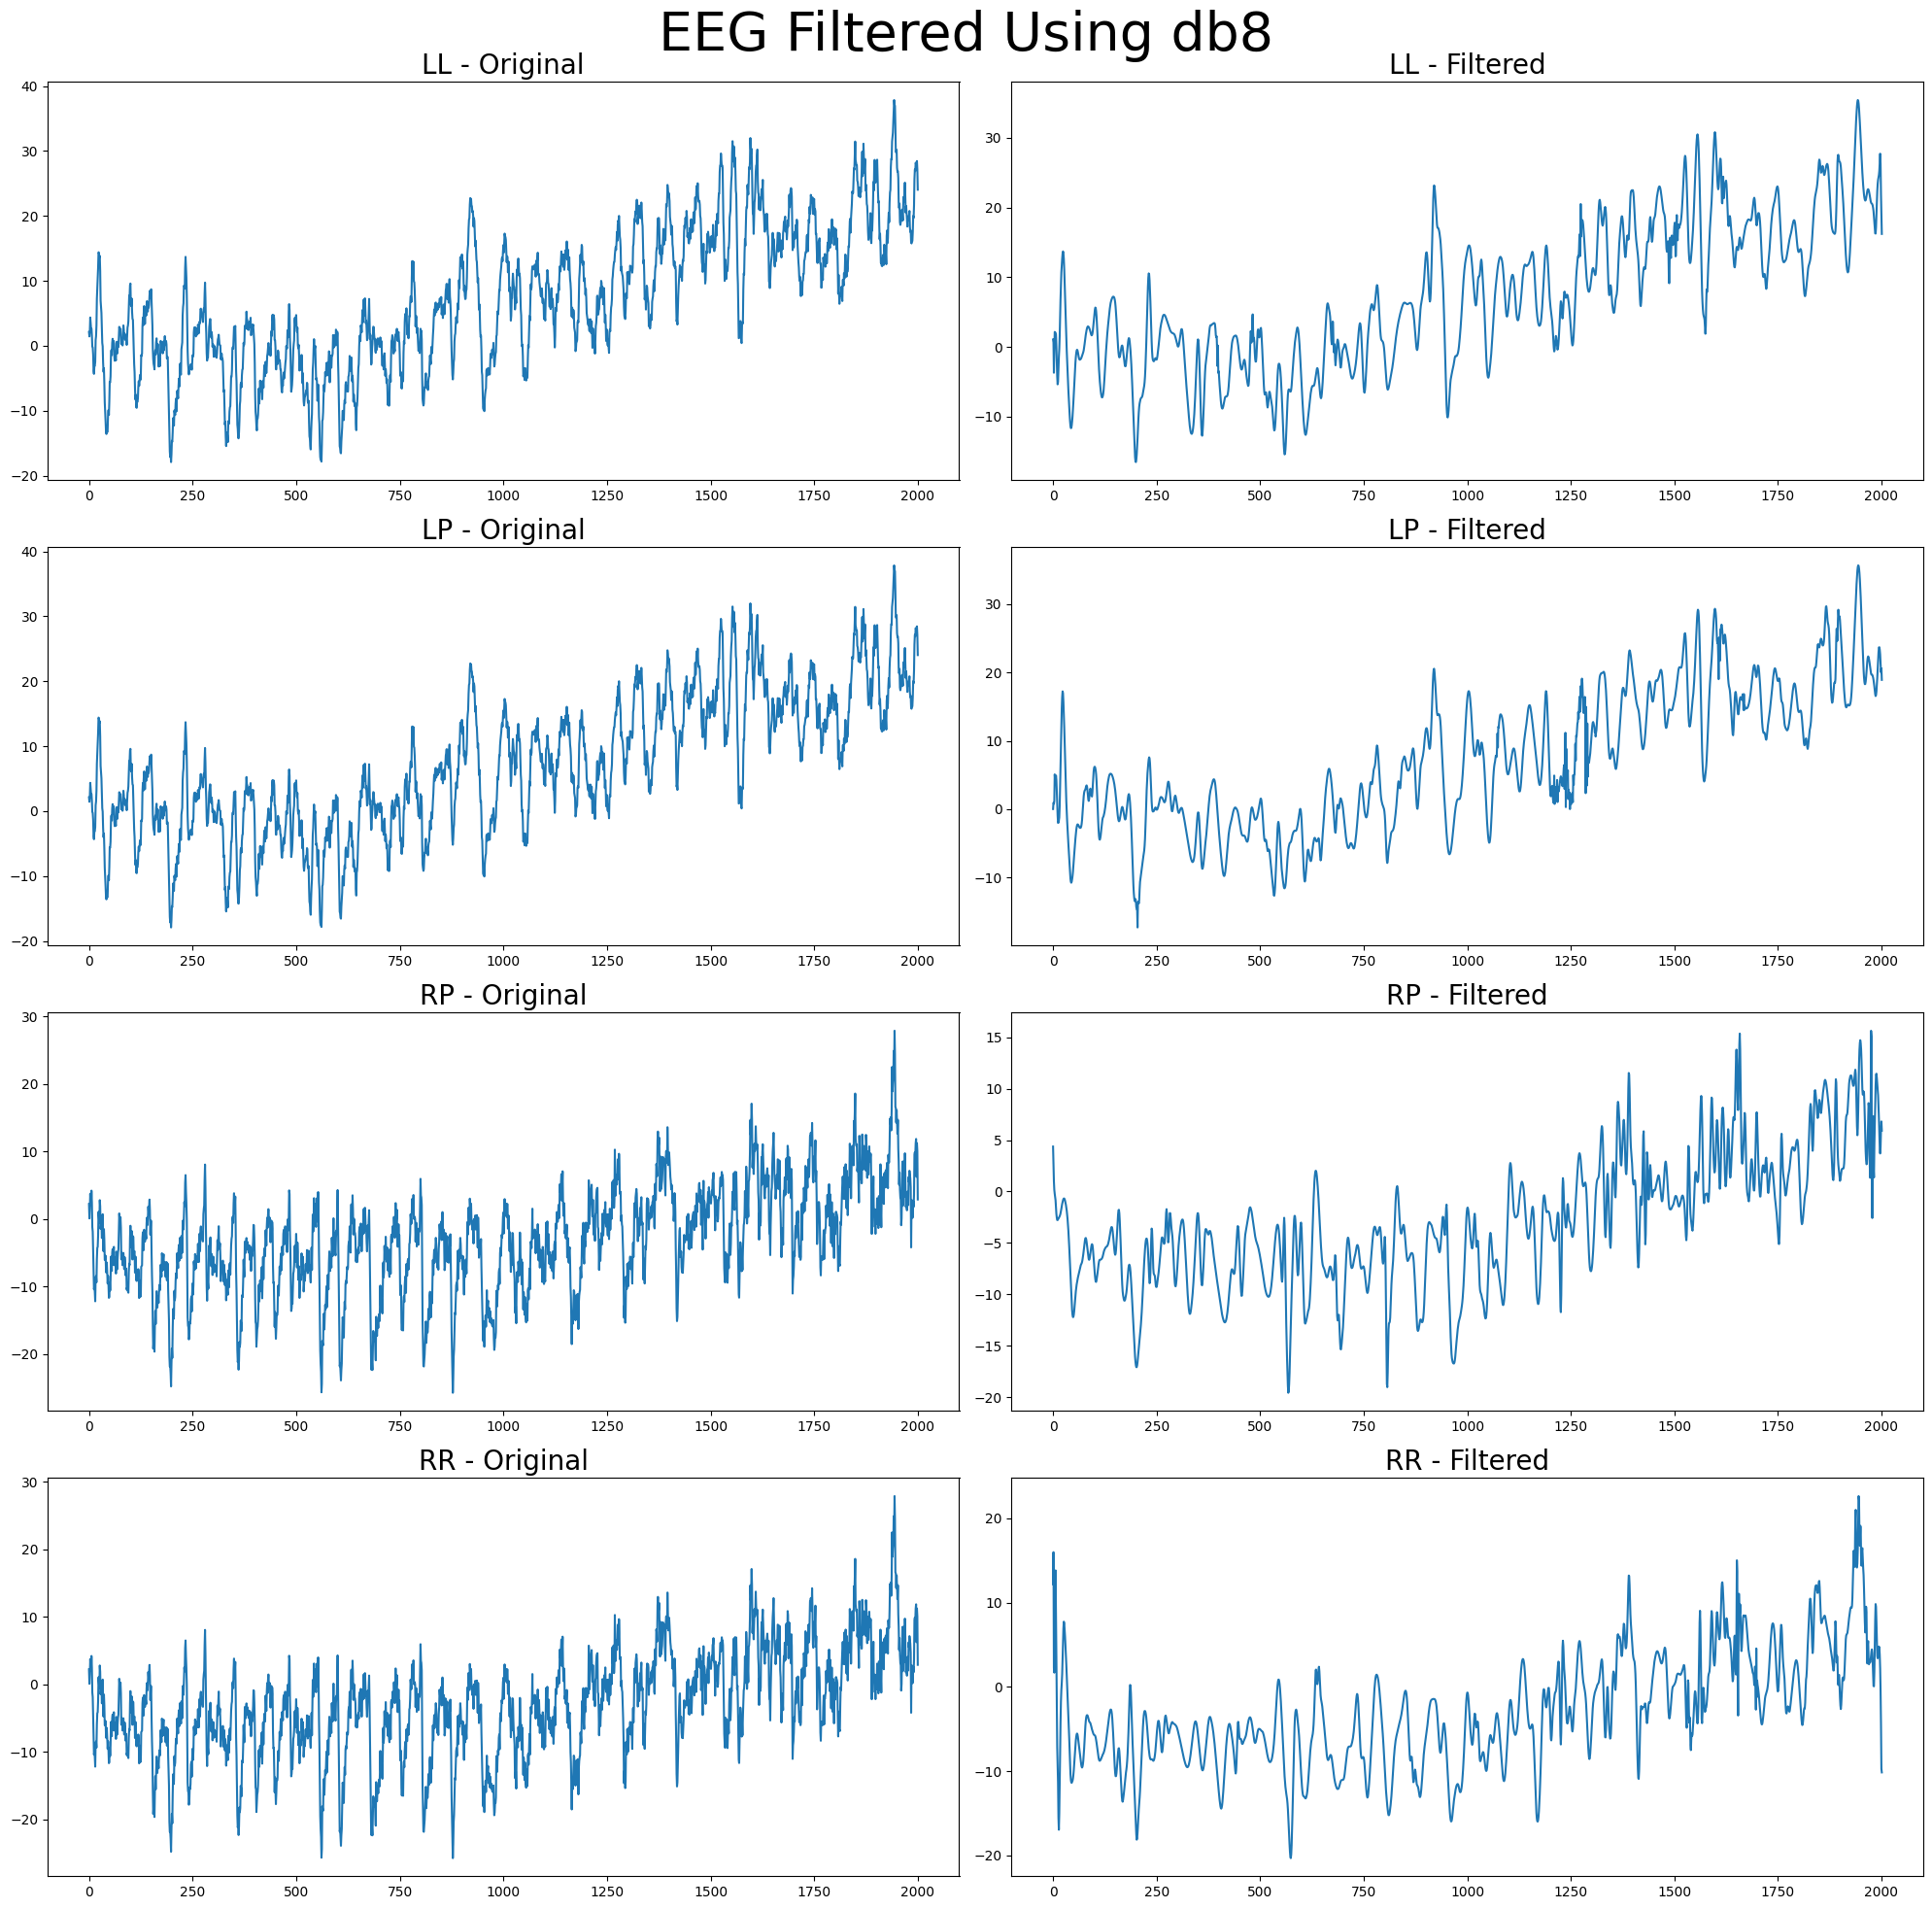

In [41]:
proc,og = processAndPlot(eeg_id = 1,USE_WAVELET='db8',plot=True)

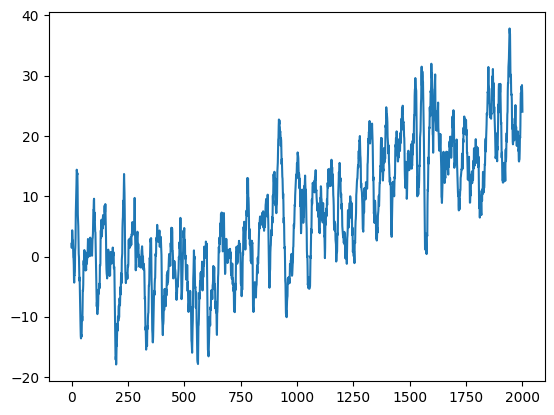

In [136]:
plt.plot(range(2001),og[0][0])

In [139]:
yyy


(2001, 20)
Image shape is: (256, 128)
Image shape is: (384, 128)
Image shape is: (512, 128)
Image shape is: (640, 128)


In [141]:
labels.shape

(6,)

In [142]:
# stackedSpecs = retSpecs[0,:,:,0]

# for i in range(1,4):
#     stackedSpecs = np.vstack((stackedSpecs,retSpecs[0,:,:,i]))
# for i in range(9):
    # plt.imshow(retSpecs[1])
print(retSpecs[0].shape)

(512, 128)


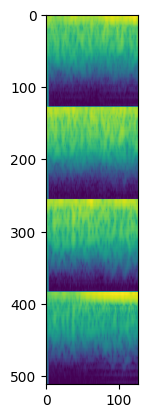

In [143]:
plt.imshow(retSpecs[0])